In [1]:
import pydeck as pdk
import ibis as ib
from ibis import _
import pandas as pd
import geopandas as gpd
import pydeck as pdk
import shapely
import numpy as np
import json
import io

ib.options.interactive = True
import pypalettes

In [2]:
import duckdb as ddb

### Data sets

https://datadryad.org/stash/dataset/doi:10.5061/dryad.6t1g1jx4f

In [3]:
# Method to plot polygons taken from: https://thedatasavvycorner.com/blogs/10-pydeck-with-gpd

# common paremeters to the deck maps
lat_center = 0
lon_center = 0

view_state = pdk.ViewState(latitude=lat_center
                           ,longitude=lon_center
                           ,zoom=1
                           ,bearing=0
                           ,pitch=0)




In [4]:
assets = ib.read_csv("datasets/doi_10_5061_dryad_6t1g1jx4f__v20231004/SFI-Global-Cement-Database-assets.csv")

In [5]:
assets.head(10)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━┓
┃ uid         ┃ city            ┃ state            ┃ country     ┃ iso3   ┃ country_code ┃ region ┃ sub_region         ┃ latitude   ┃ longitude ┃ … ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━┩
│ string      │ string          │ string           │ string      │ string │ string       │ string │ string             │ float64    │ float64   │ … │
├─────────────┼─────────────────┼──────────────────┼─────────────┼────────┼──────────────┼────────┼────────────────────┼────────────┼───────────┼───┤
│ GACTAFG0001 │ Pol-e Khomri    │ Baghlan          │ Afghanistan │ AFG    │ 4            │ Asia   │ Southern Asia      │  35.965800 │ 68.686338 │ … │
│ GACTAFG0002 │ Injil           │ Herat            │ Afghanistan │ AFG    │ 4            │ Asia   │ Southern Asia      │  34.322144 │ 61.953503 │ … │
│ GACTAGO0001 │ Luanda          │ Luanda           │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │  -8.766173 │ 13.316051 │ … │
│ GACTAGO0002 │ Cacuaco         │ Luanda           │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │  -8.796392 │ 13.426780 │ … │
│ GACTAGO0003 │ Lobito          │ Benguela         │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │ -12.342644 │ 13.581766 │ … │
│ GACTAGO0004 │ Sumbe           │ Kwanza-Sul       │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │ -11.185243 │ 14.030804 │ … │
│ GACTAGO0005 │ Ícolo e Bengo   │ Bengo            │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │  -9.101295 │ 13.567408 │ … │
│ GACTAGO0006 │ Benguela        │ Benguela         │ Angola      │ AGO    │ 24           │ Africa │ Sub-Saharan Africa │ -12.537825 │ 13.496729 │ … │
│ GACTALB0001 │ Rrethi i Lezhës │ Qarku i Lezhës   │ Albania     │ ALB    │ 8            │ Europe │ Southern Europe    │  41.836770 │ 19.633450 │ … │
│ GACTALB0002 │ Rrethi i Krujës │ Qarku i Durrësit │ Albania     │ ALB    │ 8            │ Europe │ Southern Europe    │  41.503079 │ 19.743606 │ … │
└─────────────┴─────────────────┴──────────────────┴─────────────┴────────┴──────────────┴────────┴────────────────────┴────────────┴───────────┴───┘

In [6]:
assets.columns

['uid',
 'city',
 'state',
 'country',
 'iso3',
 'country_code',
 'region',
 'sub_region',
 'latitude',
 'longitude',
 'accuracy',
 'status',
 'plant_type',
 'production_type',
 'confdnc',
 'capacity',
 'capacity_source',
 'year',
 'owner_permid',
 'owner_name',
 'owner_source',
 'parent_permid',
 'parent_name',
 'ownership_stake',
 'parent_lei',
 'parent_holding_status',
 'parent_ticker',
 'parent_exchange',
 'parent_permid_2',
 'parent_name_2',
 'ownership_stake_2',
 'parent_lei_2',
 'parent_holding_status_2',
 'parent_ticker_2',
 'parent_exchange_2',
 'sourcing',
 'raw_mtrl',
 'clinker']

In [7]:
assets_df = assets.select("uid","city","state","latitude","longitude","accuracy","production_type","capacity").to_pandas()

In [8]:
assets_df.head(5)

,uid,city,state,latitude,longitude,accuracy,production_type,capacity
0,GACTAFG0001,Pol-e Khomri,Baghlan,35.965800,68.686338,Exact,n/a,0.36
1,GACTAFG0002,Injil,Herat,34.322144,61.953503,Exact,Dry,1.00
2,GACTAGO0001,Luanda,Luanda,-8.766173,13.316051,Exact,Dry,1.20
3,GACTAGO0002,Cacuaco,Luanda,-8.796392,13.426780,Exact,Dry,1.80
4,GACTAGO0003,Lobito,Benguela,-12.342644,13.581766,Exact,Dry,0.35


<Axes: >

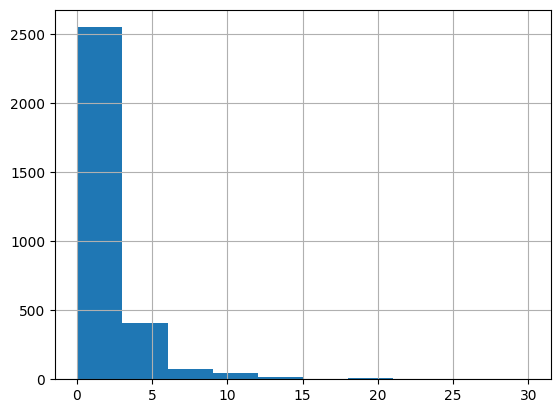

In [9]:
assets_df["capacity"].hist()

### Mapping 

In [10]:

layer_cement = pdk.Layer(
    "ScatterplotLayer",# "PolygonLayer",
    assets_df,
    pickable=True,
    opacity=1,
    stroked=True,
    filled=True,
    extruded=False,
    auto_highlight=True,
    radius_scale=3,
    radius_min_pixels=5,
    radius_max_pixels=30,
    line_width_min_pixels=1,
    get_position = ["longitude","latitude"],
    get_radius = ["capacity"],
    get_fill_color= [200,40,30],
    get_line_color=[0, 0, 0]
)

# Create mapdeck object
deck_map_cement = pdk.Deck(layers=[layer_cement]
                    ,initial_view_state=view_state
                    #  ,tooltip= {"text": """{COUNTRY_NAME}"""}
                    ,height=800
                    ,map_style="road"
                    )

In [41]:
deck_map_cement.to_html("deck_maps/cement_vis.html")